In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import seaborn as sns; sns.set()
from sklearn.utils import shuffle
from sklearn import preprocessing
from mpl_toolkits import mplot3d

data = sio.loadmat('face.mat')
face_data=data['X']
c=data['l']

num_img = face_data.shape[1] # num_img=520
num_pix = face_data.shape[0]

# split into train and test sets
img_idx_train = []
img_idx_test = []
for i in range(num_img):
    if i%10>8: #last 2 feed into test set
        img_idx_test.append(i)
    else:
        img_idx_train.append(i)
#training set
img_train = np.delete(face_data, img_idx_test, 1) # 2576*img_train.shape[1]
#test set
img_test = np.delete(face_data, img_idx_train, 1) # 2576*img_test.shape[1]

In [3]:
# PCA dimension reduction
img_mean = img_train.mean(axis=1)
img_norm = img_train - img_mean[:,None] # img_norm is 2576*img_train.shape[1]
print(img_norm.shape)
S=np.divide(np.matmul(img_norm.T,img_norm),468)
eigvals, eigvecs = np.linalg.eig(S)
# sort eigvals in descending order
idx = eigvals.argsort()[::-1]   
eigval = eigvals[idx]
eigvec = eigvecs[:,idx]
eigvecs = np.matmul(img_norm,eigvec) # 2576*9 
eigvals = preprocessing.normalize(eigvecs, norm='l2', axis=0)
# use first M eigenvectors for reconstruction
# M=70
# w=np.matmul(img_norm.T, eigvecs[:,:M]) # w_n consists of M eigen coefficients
# w=w.T


(2576, 468)


In [4]:
# LDA  
# compute class mean
class_mean=np.zeros((num_pix,52))
for i in range(52):
    class_mean[:,i]=img_train[:,i*9:i*9+9].mean(axis=1)

img_norm_split = np.split(img_norm, 52, axis = 1)
class_mean_split = np.split(class_mean, 52, axis = 1)     
# compte S_b
S_b=np.zeros((num_pix,num_pix))
img_mean = img_mean.reshape(2576, 1)
for i in range(52):
    mean_vec = class_mean_split[i].reshape(2576, 1)
    S_b +=  np.dot((mean_vec-img_mean),(mean_vec-img_mean).T)
# compute S_w
del mean_vec
img_norm_split = np.split(img_norm, 52, axis = 1)
class_mean_split = np.split(class_mean, 52, axis = 1)   
S_w=np.zeros((num_pix,num_pix))
for i in range(52):
    img_norm_split[i] = img_norm_split[i] - np.squeeze(class_mean_split[i])[:,None]
    S_w += np.matmul(img_norm_split[i],img_norm_split[i].T)
   


(250, 250)


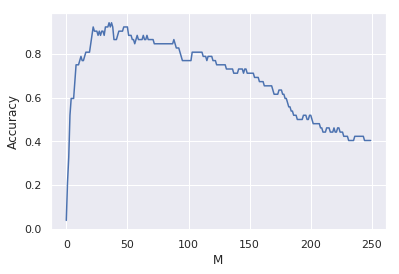

In [5]:
# recogiton for various M_lda
img_mean_test = img_test.mean(axis=1)
img_norm_test = img_test - img_mean_test[:,None] # img_norm_test is 2576*img_test.shape[1]
M_pca=250
W_pca=eigvecs[:,:M_pca]
# compute generalized eigvecs and eigvals
temp = np.matmul((np.linalg.pinv(np.matmul(np.matmul(W_pca.T,S_w),W_pca))), (np.matmul(np.matmul(W_pca.T,S_b),W_pca)))
print(temp.shape)

# sort eigvals and eigvecs in descending order
eigvals_gen, eigvecs_gen = np.linalg.eig(temp)
idx_gen = eigvals_gen.argsort()[::-1]   
eigvals_gen = eigvals_gen[idx_gen]
eigvecs_gen = eigvecs_gen[:,idx_gen]

M_lda=250 # survey up to M_lda

acc_plot=np.zeros((M_lda,1))
for M_lda in range (1,M_lda+1):
    W_lda=eigvecs_gen[:,:M_lda]
    W_opt=np.matmul(W_lda.T,W_pca.T).T # shape 2576*25
    w_n = np.matmul(img_norm.T, W_opt)
    w = np.matmul(img_norm_test.T, W_opt)
    e_NN=np.zeros((img_train.shape[1],1))
    count=0
    for i in range(img_test.shape[1]):          
        for j in range(img_train.shape[1]):
            e_NN[j]=np.linalg.norm(w[i,:]-w_n[j,:])
        idx_val=np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
        id_pred=int(img_idx_train[idx_val]/10)+1 # predicted label
        id_true=int(img_idx_test[i]/10)+1 # ground truth label  
        if id_pred == id_true:
            count+=1
    accuracy=count/img_test.shape[1]
    acc_plot[M_lda-1]=accuracy  
plt.plot(acc_plot)
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.show()        

(250, 120)


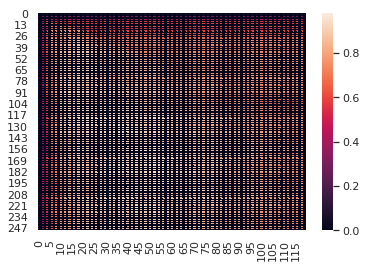

In [27]:
# for all M_pca and M_lda

M_pca=250 # hyperparameter
M_lda=120 # hyperparameter
acc_plot=np.zeros((M_pca,M_lda))
for M1 in range(1,M_pca+1,2):
    W_pca=eigvecs[:,:M1]
    # compute generalized eigvecs and eigvals
    temp = np.matmul((np.linalg.pinv(np.matmul(np.matmul(W_pca.T,S_w),W_pca))), (np.matmul(np.matmul(W_pca.T,S_b),W_pca)))
    # sort eigvals and eigvecs in descending order
    eigvals_gen, eigvecs_gen = np.linalg.eig(temp)
    idx_gen = eigvals_gen.argsort()[::-1]   
    eigvals_gen = eigvals_gen[idx_gen]
    eigvecs_gen = eigvecs_gen[:,idx_gen]

    for M2 in range (1,M_lda+1,2):
        W_lda=eigvecs_gen[:,:M2]
        W_opt=np.matmul(W_pca,W_lda) # shape 2576*25
        w_n = np.matmul(img_norm.T, W_opt)
        w = np.matmul(img_norm_test.T, W_opt)
        e_NN=np.zeros((img_train.shape[1],1))
        count=0
        for i in range(img_test.shape[1]):          
            for j in range(img_train.shape[1]):
                e_NN[j]=np.linalg.norm(w[i,:]-w_n[j,:])
            idx_val=np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
            id_pred=int(img_idx_train[idx_val]/10)+1 # predicted label
            id_true=int(img_idx_test[i]/10)+1 # ground truth label  
            if id_pred == id_true:
                count+=1
        accuracy=count/img_test.shape[1]
        acc_plot[M1-1,M2-1]=accuracy  

print(acc_plot.shape)
ax = sns.heatmap(acc_plot)


In [46]:
# for all M_pca and M_lda

M_pca=200 # hyperparameter
M_lda=50 # hyperparameter
acc_plot=np.zeros((int(M_pca/2),int(M_lda/2)))
for M1 in range(1,M_pca+1,2):
    W_pca=eigvecs[:,:M1]
    # compute generalized eigvecs and eigvals
    temp = np.matmul((np.linalg.pinv(np.matmul(np.matmul(W_pca.T,S_w),W_pca))), (np.matmul(np.matmul(W_pca.T,S_b),W_pca)))
    # sort eigvals and eigvecs in descending order
    eigvals_gen, eigvecs_gen = np.linalg.eig(temp)
    idx_gen = eigvals_gen.argsort()[::-1]   
    eigvals_gen = eigvals_gen[idx_gen]
    eigvecs_gen = eigvecs_gen[:,idx_gen]

    for M2 in range (1,M_lda+1,2):
        W_lda=eigvecs_gen[:,:M2]
        W_opt=np.matmul(W_pca,W_lda) # shape 2576*25
        w_n = np.matmul(img_norm.T, W_opt)
        w = np.matmul(img_norm_test.T, W_opt)
        e_NN=np.zeros((img_train.shape[1],1))
        count=0
        for i in range(img_test.shape[1]):          
            for j in range(img_train.shape[1]):
                e_NN[j]=np.linalg.norm(w[i,:]-w_n[j,:])
            idx_val=np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
            id_pred=int(img_idx_train[idx_val]/10)+1 # predicted label
            id_true=int(img_idx_test[i]/10)+1 # ground truth label  
            if id_pred == id_true:
                count+=1
        accuracy=count/img_test.shape[1]
        acc_plot[int((M1-1)/2),int((M2-1)/2)]=accuracy  

max_M_pca=argmax(acc_plot)
acc_plot_norm=acc_plot-np.mean(acc_plot)       
print(acc_plot.shape)
ax = sns.heatmap(acc_plot_norm, center=0.1)


NameError: name 'argmax' is not defined

(100, 25)


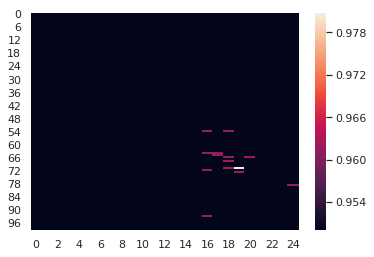

In [57]:
acc_plot[acc_plot < 0.95] = 0.95
acc_plot_norm=acc_plot-np.mean(acc_plot)       
print(acc_plot.shape)
ax = sns.heatmap(acc_plot)